In [7]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import seaborn as sns

sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)

# 第六章 学习空间特征

本章依赖的类库有：

- numpy 快速操作结构数组的工具
- opencv 视觉处理库
- matplotlib 画图工具
- seaborn 基于matplotlib封装的统计绘图工具
- keras 二次封装的深度学习库
- tensorflow 深度学习库
- caffe 深度学习库

python类库安装教程见实体书附录A，深度学习库安装教程见实体书附录B。

____

## 6.1 预处理空间数据

### 过滤冗余

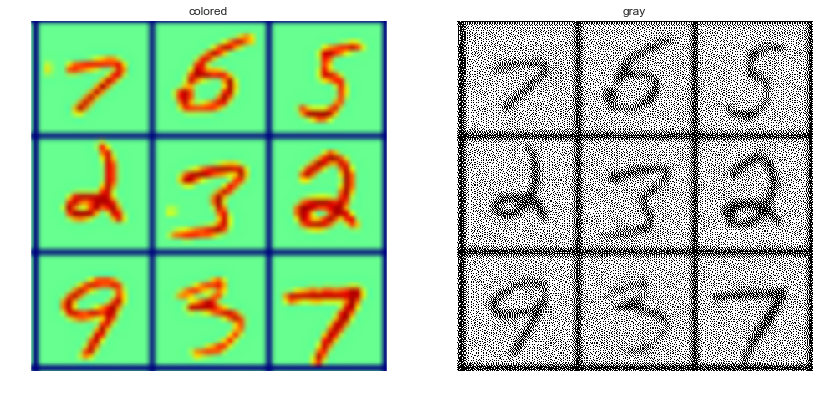

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

img_color = Image.open("img/6/mnist_color.png") # 原始色彩图
img_gray = img_color.convert('1') # 转换成黑白图

fig, (ax1, ax2) = plt.subplots(1, 2) # 1行，每行2张plot，对比

ax1.axis("off") # 关闭坐标轴
ax2.axis("off")
ax1.set_title('colored')
ax1.imshow(img_color)
ax2.set_title('gray')
ax2.imshow(img_gray)

### 生成数据

#### 实物特征的空间不变性


In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# 更多API参见官方文档“图片预处理”。https://keras-cn.readthedocs.io/en/latest/preprocessing/image/"""

DIR = './data/moredata/'

# 随机变形手段的组合
pic_gener = ImageDataGenerator(
    rotation_range=20, # 随机旋转角度范围
    width_shift_range=0.1, # 随机水平移动的范围
    height_shift_range=0.2, # 随机竖直移动的范围
    shear_range=0.2, # 裁剪程度
    zoom_range=0.5, # 随机局部放大的程度
    horizontal_flip=True, # 水平翻转
    fill_mode='nearest') # 当旋转、位移导致图片像素空缺时，填充新像素的方式

img = load_img(DIR + 'dog.png')  # 加载成PIL图片 400*400
x = img_to_array(img)  # 转换成 (400, 400, 3)，第一个数字代表通道数量（RGB颜色通道：3个）
x = x.reshape((1,) + x.shape)  # 转换成Keras/Tensorflow的“tf”格式 (1, 400, 400, 3)第一个数字代表图片数量

i = 0
# 生成随机“变形”的图片；这里可以用flow对单张图片处理，也可以用flow_from_directory对文件夹内所有图片处理
for batch in pic_gener.flow(x, batch_size=1,
                          save_to_dir=DIR[:-1], save_prefix='gen', save_format='png'):
    i += 1
    if i > 30: break # 生成30张    

Using TensorFlow backend.


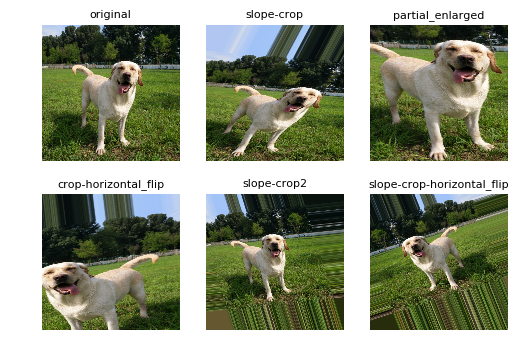

In [7]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3) # 2行，每行3张plot
for ax in (ax1, ax2, ax3, ax4, ax5, ax6):
    ax.axis("off") # 关闭坐标轴

# 看几张生成的图片
TITLE_SIZE = 8
ax1.set_title('original', fontsize=TITLE_SIZE)
ax1.imshow(img)
ax2.set_title('slope-crop', fontsize=TITLE_SIZE)
ax2.imshow(load_img(DIR + 'gen_0_2403.png'))
ax3.set_title('partial_enlarged', fontsize=TITLE_SIZE)
ax3.imshow(load_img(DIR + 'gen_0_3380.png'))
ax4.set_title('crop-horizontal_flip', fontsize=TITLE_SIZE)
ax4.imshow(load_img(DIR + 'gen_0_448.png'))
ax5.set_title('slope-crop2', fontsize=TITLE_SIZE)
ax5.imshow(load_img(DIR + 'gen_0_3582.png'))
ax6.set_title('slope-crop-horizontal_flip', fontsize=TITLE_SIZE)
ax6.imshow(load_img(DIR + 'gen_0_4009.png'))
plt.show()

## 6.2 描述图片的空间特征：特征图



### 图片的卷积运算


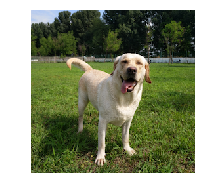

展示一部分图片像素值:
[[[179 199 239]
  [178 198 240]]

 [[190 205 237]
  [186 203 238]]]


In [8]:
import numpy as np
import cv2 # OpenCV是一个非常棒的视觉处理库，cv2是OpenCV的Python版

DIR = './data/moredata/'
img = cv2.imread(DIR + 'dog.png') 
f = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2用BGR格式编码图片，转换成RGB存储

def show_img(img):
    """展示图片"""
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

show_img(f)
print('展示一部分图片像素值:\n' + str(f[:2, :2])) # 按RGB编码，0-255的像素数值

In [9]:
g = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]], dtype='float32')

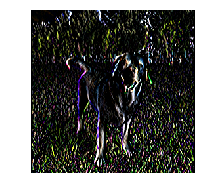

In [10]:
# 执行卷积运算，也就是cv2的filter2D。命名filter源自信号滤波的概念，本节后面会提到
cov = cv2.filter2D(f, -1, g) 

show_img(cov)

### 卷积指令和特征图

In [11]:
img_bgr = cv2.imread(DIR + 'dog.png')  # 原始图片
origin = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # cv2用BGR格式编码图片，这行代码转换成RGB存储的

kernal_do_nothing = np.array([[0, 0, 0],[0, 1, 0],[0, 0, 0]], dtype='float32') # 用float类型计算

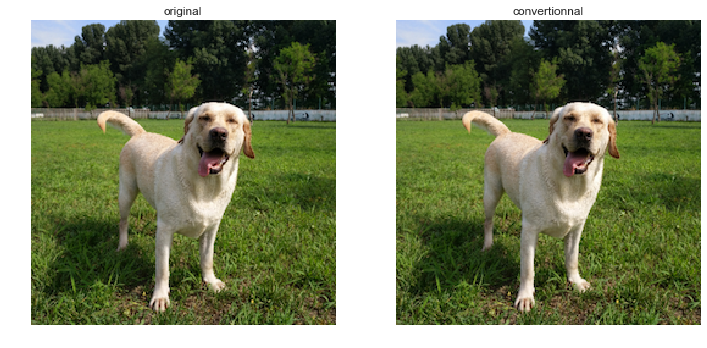

In [12]:
def compare_imgs(imgs, titles=[]):
    """对比图片"""
    n = len(imgs)
    titles = titles if titles else [''] * n # 标题，没传初始化为等长的空list
    fig, axes = plt.subplots(1, n, figsize=(12, 12))
    for ax, img, title in zip(axes, imgs, titles):
        ax.axis("off") # 关闭坐标轴
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
    plt.show()

cov = cv2.filter2D(origin, -1, kernal_do_nothing) # 执行卷积运算
compare_imgs([origin, cov], ['original', 'convertionnal'])

In [13]:
g = np.ones((3, 3), dtype='float32') # 均值模糊
kernal_mean = g / np.sum(g) # 让卷积核数组归一化，所有参数加起来等于1

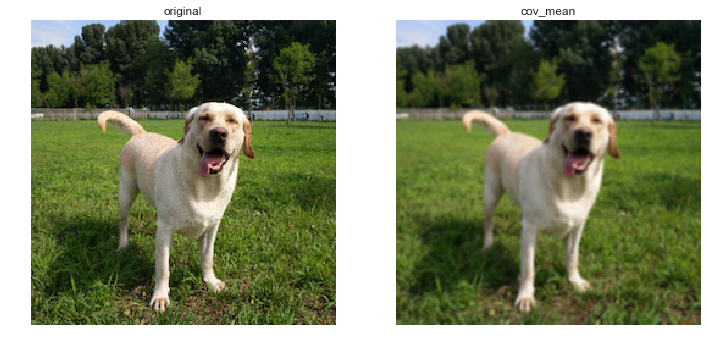

In [14]:
cov = cv2.filter2D(origin, -1, kernal_mean) # 执行卷积运算
compare_imgs([origin, cov], ['original', 'cov_mean'])

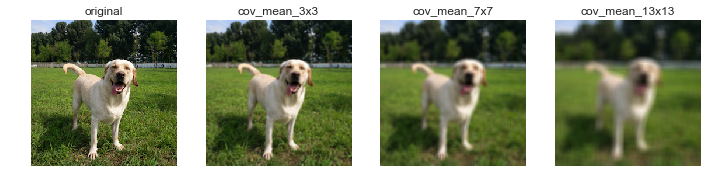

In [15]:
g3 = np.ones((3, 3), dtype='float32') # 均值模糊
kernal_mean3 = g3 / np.sum(g3) # 让卷积核数组归一化，所有参数加起来等于1

g7 = np.ones((7, 7), dtype='float32') 
kernal_mean7 = g7 / np.sum(g7) 

g13 = np.ones((13, 13), dtype='float32') 
kernal_mean13 = g13 / np.sum(g13) 

cov3 = cv2.filter2D(origin, -1, kernal_mean3) # 执行卷积运算
cov7 = cv2.filter2D(origin, -1, kernal_mean7) 
cov13 = cv2.filter2D(origin, -1, kernal_mean13) 
compare_imgs([origin, cov3, cov7, cov13], ['original', 'cov_mean_3x3', 'cov_mean_7x7', 'cov_mean_13x13'])

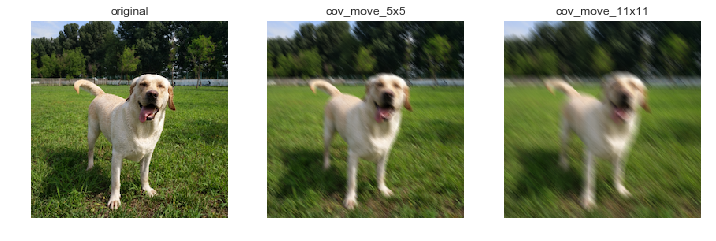

In [16]:
g5 = np.identity(5, dtype='float32') # 运动模糊
kernal_move5 = g5 / np.sum(g5) 
g11 = np.identity(11, dtype='float32') # 高阶卷积核上看效果更明显
kernal_move11 = g11 / np.sum(g11) 


cov5 = cv2.filter2D(origin, -1, kernal_move5) # 执行卷积运算 
cov11 = cv2.filter2D(origin, -1, kernal_move11)
compare_imgs([origin, cov5, cov11], ['original', 'cov_move_5x5', 'cov_move_11x11'])

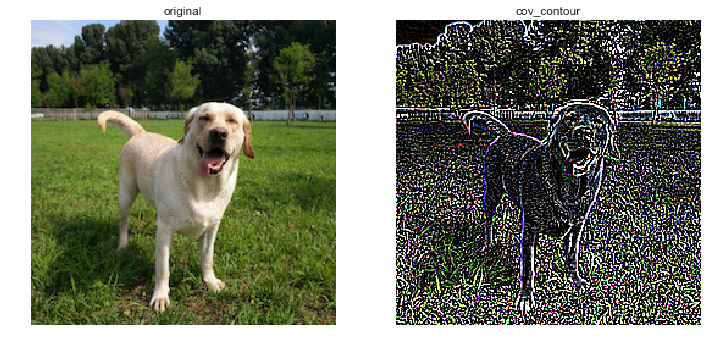

In [17]:
# 轮廓卷积核；同时放大2倍，让凸显效果清楚一点
kernal_contour = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]], dtype='float32') * 2

cov = cv2.filter2D(origin, -1, kernal_contour) # 执行卷积运算 
compare_imgs([origin, cov], ['original', 'cov_contour'])

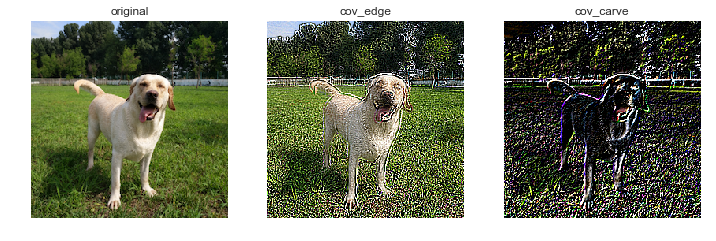

In [18]:
# 边缘卷积核，参数和加起来大于1，图片会更亮一些；像素指令：加强周边，抑制自身
kernal_edge = np.array([[1, 1, 1],[1, -7, 1],[1, 1, 1]], dtype='float32') 

# 浮雕卷积核，一种3D阴影效果。指令是将中心点一边的像素减去中心或者另一边的像素；倍数代表放大的程度
kernal_carve = np.array([[-1, -1, 0],[-1, 3, 0],[0, 0, 0]], dtype='float32') * 3

cov_edge = cv2.filter2D(origin, -1, kernal_edge) # 执行卷积运算 
cov_carve = cv2.filter2D(origin, -1, kernal_carve) 

compare_imgs([origin, cov_edge, cov_carve], ['original', 'cov_edge', 'cov_carve'])

## 6.4 CNN模型II：图片识别

### 连接分类模型

In [19]:
from keras.layers import MaxPooling2D, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Convolution2D, Activation

# 套路：卷积-激活-池化
model = Sequential([
Convolution2D(32, 3, 3, input_shape=(128, 128, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Convolution2D(64, 3, 3, activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Flatten(),
])

In [20]:
from keras.layers import Dense

# 追加DNN层
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

### 猫狗分类

从[kaggle猫狗分类任务数据集](https://www.kaggle.com/c/dogs-vs-cats/data)下载完整的样本集train.zip，解压到./data/dog_cat/train/

我们只使用train.zip作为全部数据集实验

In [1]:
import os
import shutil
import random

# 从https://www.kaggle.com/c/dogs-vs-cats/data下载完整的样本集train.zip，解压到下面的目录
train = './data/dog_cat/train/' 

dogs = [train + i for i in os.listdir(train) if 'dog' in i]
cats = [train + i for i in os.listdir(train) if 'cat' in i]
print('dogs count:' + str(len(dogs)))
print('cats count:' + str(len(cats)))

dogs count:12500
cats count:12500


In [2]:
target = './data/dog_cat/arrange/' # 目标训练集地址

# 随机化
random.shuffle(dogs)
random.shuffle(cats)

def ensure_dir(dir_path):
    if not os.path.exists(dir_path):
        try:
            os.makedirs(dir_path)
        except OSError:
            pass

# 生成文件夹
ensure_dir(target + 'train/dog')
ensure_dir(target + 'train/cat')
ensure_dir(target + 'validation/dog')
ensure_dir(target + 'validation/cat')

# 复制图片
for dog_file, cat_file in zip(dogs, cats)[:1000]:
    shutil.copyfile(dog_file, target + 'train/dog/' + os.path.basename(dog_file))
    shutil.copyfile(cat_file, target + 'train/cat/' + os.path.basename(cat_file))

for dog_file, cat_file in zip(dogs, cats)[1000:1500]:
    shutil.copyfile(dog_file, target + 'validation/dog/' + os.path.basename(dog_file))
    shutil.copyfile(cat_file, target + 'validation/cat/' + os.path.basename(cat_file))

In [3]:
from keras.preprocessing.image import ImageDataGenerator

# 图片尺寸
img_width, img_height = 128, 128
input_shape = (img_width, img_height, 3)

train_data_dir = target + 'train'
validation_data_dir = target + 'validation'

# 生成变形图片
train_pic_gen = ImageDataGenerator(
        rescale=1./255, # 对输入图片归一化到0-1区间
        rotation_range=20, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.5, 
        horizontal_flip=True, # 水平翻转
        fill_mode='nearest')

# 测试集不做变形处理，只需要归一化。关于为什么要做归一化，参见1.4 逻辑分类II：线性分类模型-去均值和归一化
validation_pic_gen = ImageDataGenerator(rescale=1./255)

Using TensorFlow backend.


In [4]:
# 按文件夹生成训练集流和标签，binary：二分类
train_flow = train_pic_gen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

# 按文件夹生成测试集流和标签
validation_flow = validation_pic_gen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

steps_per_epoch = 2000
validation_steps = 1000
#epochs = 1
epochs = 50 # 循环50轮

# 两层卷积-池化，提取64个平面特征
model = Sequential([
Convolution2D(32, (3, 3), input_shape=input_shape, activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Convolution2D(64, (3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Flatten(),
Dense(64, activation='relu'),
Dropout(0.5),
Dense(1, activation='sigmoid'),
])

# 损失函数设置为二分类交叉熵
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

对于15寸顶配Mac，每个epochs约跑15分钟以上

In [6]:
model.fit_generator(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_flow,
        validation_steps=validation_steps)

Epoch 1/1
2000/2000 [==============================] - 1510s - loss: 0.7093 - acc: 0.6548 - val_loss: 0.5205 - val_acc: 0.7339

In [7]:
ensure_dir(target + 'weights')
model.save_weights(target + 'weights/' + '1.h5')

## 6.5 CNN的实现模型

#### Caffe实现VGG16模型

见第六章目录下文件。

## 6.6 微训练模型（fine-tuning）

可以从[这里](https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5)直接下载模型文件，存储到~/.keras/models下即可

In [ ]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet')

#### 更换DNN模型结构


In [8]:
from keras.models import Model
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16

# 图片尺寸
img_width, img_height = 128, 128
input_shape = (img_width, img_height, 3)

可以从[这里](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5)直接下载模型文件，存储到`~/.keras/models`下即可

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [11]:
from keras.layers import Dropout, Flatten, Dense

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
y = Dense(1, activation='sigmoid')(x)

model = Model(input=base_model.input, output=y)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# 数据地址
target = './data/dog_cat/arrange/'
train_data_dir = target + 'train'
validation_data_dir = target + 'validation'

# 模型参数
steps_per_epoch = 2000
validation_steps = 1000
#epochs = 1
epochs = 50 # 循环50轮

# 生成变形图片，并做去均值处理，已做好的可以省略这步，延续之前生存的变形图片
train_pic_gen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# 测试集不做变形处理，只需要去均值
validation_pic_gen = ImageDataGenerator(rescale=1./255)

# 按文件夹生成训练集流和标签
train_flow = train_pic_gen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

# 按文件夹生成测试集流和标签
validation_flow = validation_pic_gen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# 冻结VGG中ImageNet的CNN结构部分，让ImageNet训练好的参数不变
for layer in base_model.layers:
    layer.trainable = False 

对于15寸顶配Mac，每个epoch约跑1小时以上

In [14]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit_generator(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_flow,
        validation_steps=validation_steps)

Epoch 1/1
2000/2000 [==============================] - 13665s - loss: 0.2937 - acc: 0.8805 - val_loss: 0.4371 - val_acc: 0.8797

In [15]:
model.save_weights('merge_model.h5')

#### 微调连接部分


In [16]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

(0, 'input_1')
(1, 'block1_conv1')
(2, 'block1_conv2')
(3, 'block1_pool')
(4, 'block2_conv1')
(5, 'block2_conv2')
(6, 'block2_pool')
(7, 'block3_conv1')
(8, 'block3_conv2')
(9, 'block3_conv3')
(10, 'block3_pool')
(11, 'block4_conv1')
(12, 'block4_conv2')
(13, 'block4_conv3')
(14, 'block4_pool')
(15, 'block5_conv1')
(16, 'block5_conv2')
(17, 'block5_conv3')
(18, 'block5_pool')
(19, 'flatten_2')
(20, 'dense_3')
(21, 'dropout_2')
(22, 'dense_4')


In [17]:
for layer in model.layers[:15]:
    layer.trainable = False
for layer in model.layers[15:]:
    layer.trainable = True

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# 微调训练
model.fit_generator(
        train_flow,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_flow,
        validation_steps=validation_steps)

Epoch 1/1
2000/2000 [==============================] - 15058s - loss: 0.0694 - acc: 0.9738 - val_loss: 0.3742 - val_acc: 0.9261